# Healthcare Readmission Predictive Analytics
## A Machine Learning Approach to Reducing Hospital Readmissions

This notebook implements a comprehensive analysis and predictive modeling solution for healthcare patient readmission using the Diabetes 130-US hospitals dataset.

## 1. Setup and Data Loading

First, let's import the necessary libraries and load our dataset.

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
from imblearn.over_sampling import SMOTE

# Set visualization style
sns.set(style='whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')

# Display settings for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 1000)

In [5]:
# Load the dataset
data_path = '../data/raw/'
diabetic_data = pd.read_csv(data_path + 'diabetic_data.csv')
ids_mapping = pd.read_csv(data_path + 'IDS_mapping.csv')

# Display basic information about the dataset
print(f"Dataset shape: {diabetic_data.shape}")
diabetic_data.head()

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [6]:
# Check for missing values
missing_values = diabetic_data.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing values in each column:")
print(missing_values)

# Check for '?' values which represent missing data in this dataset
question_marks = {}
for col in diabetic_data.columns:
    if diabetic_data[col].dtype == 'object':
        question_mark_count = (diabetic_data[col] == '?').sum()
        if question_mark_count > 0:
            question_marks[col] = question_mark_count

print("\nColumns with '?' values (representing missing data):")
for col, count in question_marks.items():
    print(f"{col}: {count} ({count/len(diabetic_data)*100:.2f}%)")

Missing values in each column:
max_glu_serum    96420
A1Cresult        84748
dtype: int64

Columns with '?' values (representing missing data):
race: 2273 (2.23%)
weight: 98569 (96.86%)
payer_code: 40256 (39.56%)
medical_specialty: 49949 (49.08%)
diag_1: 21 (0.02%)
diag_2: 358 (0.35%)
diag_3: 1423 (1.40%)


## 2. Data Preprocessing

Let's clean and prepare the data for analysis and modeling.

In [13]:
# Create a copy of the original data
df = diabetic_data.copy()

# Replace '?' with 'None' for categorical variables
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('?', 'None')

# Convert 'readmitted' to binary (0: Not readmitted, 1: Readmitted)
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 0 if x == 'NO' else 1)

# Convert age ranges to numeric values (midpoint of the range)
def age_to_numeric(age_range):
    if age_range == '[0-10)':
        return 5
    elif age_range == '[10-20)':
        return 15
    elif age_range == '[20-30)':
        return 25
    elif age_range == '[30-40)':
        return 35
    elif age_range == '[40-50)':
        return 45
    elif age_range == '[50-60)':
        return 55
    elif age_range == '[60-70)':
        return 65
    elif age_range == '[70-80)':
        return 75
    elif age_range == '[80-90)':
        return 85
    elif age_range == '[90-100)':
        return 95
    else:
        return None

df['age_numeric'] = df['age'].apply(age_to_numeric)

# Create age groups for easier analysis
def age_group(age):
    if age < 30:
        return '<30'
    elif age < 51:
        return '30-50'
    elif age < 71:
        return '51-70'
    else:
        return '>70'

df['age_group'] = df['age_numeric'].apply(age_group)

# Convert glucose serum test result to numeric
glucose_mapping = {'None': 0, 'Norm': 1, '>200': 2, '>300': 3}
df['max_glu_serum_numeric'] = df['max_glu_serum'].map(glucose_mapping)

# Convert A1C test result to numeric
a1c_mapping = {'None': 0, 'Norm': 1, '>7': 2, '>8': 3}
df['A1Cresult_numeric'] = df['A1Cresult'].map(a1c_mapping)

# Encode categorical variables
categorical_cols = ['gender', 'race', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])

# Ensure both columns have the same data type before merging
df['admission_type_id'] = df['admission_type_id'].astype(str)
ids_mapping['admission_type_id'] = ids_mapping['admission_type_id'].astype(str)

# Merge with IDS_mapping to get admission type descriptions
df = pd.merge(df, ids_mapping, on='admission_type_id', how='left')

# Save the processed dataset
os.makedirs('../data/processed', exist_ok=True)
df.to_csv('../data/processed/diabetic_data_cleaned.csv', index=False)

print("Data preprocessing completed.")
print(f"Processed dataset shape: {df.shape}")
df.head()

Data preprocessing completed.
Processed dataset shape: (305298, 61)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,readmitted_binary,age_numeric,age_group,max_glu_serum_numeric,A1Cresult_numeric,gender_encoded,race_encoded,admission_type_id_encoded,discharge_disposition_id_encoded,admission_source_id_encoded,description
0,2278392,8222157,Caucasian,Female,[0-10),None,6,25,1,1,None,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,None,None,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,5,<30,NaN,NaN,0,2,5,23,0,NaN
1,2278392,8222157,Caucasian,Female,[0-10),None,6,25,1,1,None,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,None,None,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,5,<30,NaN,NaN,0,2,5,23,0,Discharged/transferred to home with home healt...
2,2278392,8222157,Caucasian,Female,[0-10),None,6,25,1,1,None,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,None,None,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,0,5,<30,NaN,NaN,0,2,5,23,0,Transfer from another health care facility
3,149190,55629189,Caucasian,Female,[10-20),None,1,1,7,3,None,None,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,1,15,<30,NaN,NaN,0,2,0,0,6,Emergency
4,149190,55629189,Caucasian,Female,[10-20),None,1,1,7,3,None,None,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30,1,15,<30,NaN,NaN,0,2,0,0,6,Discharged to home


## 3. Exploratory Data Analysis

Let's explore the data to understand patterns and relationships.

Readmission Counts:
Not Readmitted (0): 164592 (53.91%)
Readmitted (1): 140706 (46.09%)


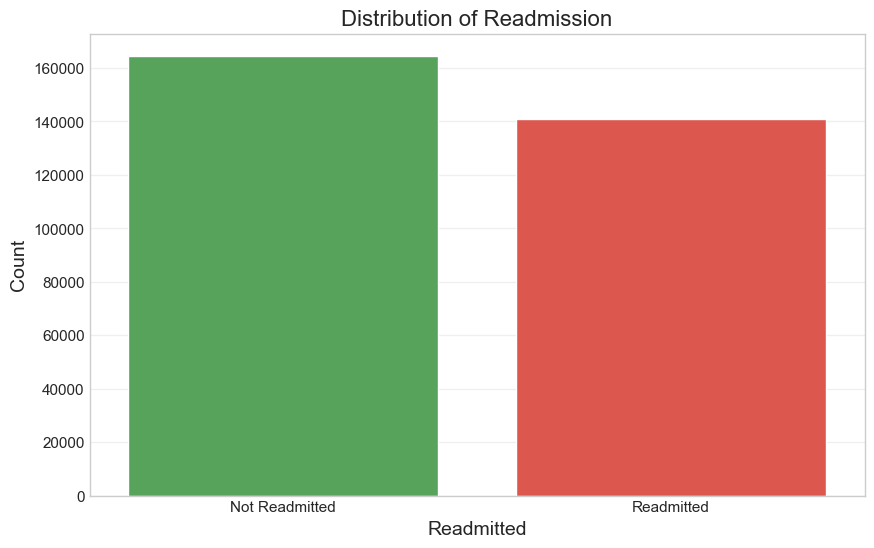

In [14]:
# Create directory for visualizations
os.makedirs('../data/visualizations', exist_ok=True)

# 1. Readmission Distribution
readmission_counts = df['readmitted_binary'].value_counts()
readmission_percentages = df['readmitted_binary'].value_counts(normalize=True) * 100

print("Readmission Counts:")
print(f"Not Readmitted (0): {readmission_counts[0]} ({readmission_percentages[0]:.2f}%)")
print(f"Readmitted (1): {readmission_counts[1]} ({readmission_percentages[1]:.2f}%)")

plt.figure(figsize=(10, 6))
sns.countplot(x='readmitted_binary', data=df, palette=['#4CAF50', '#F44336'])
plt.title('Distribution of Readmission', fontsize=16)
plt.xlabel('Readmitted', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks([0, 1], ['Not Readmitted', 'Readmitted'])
plt.grid(axis='y', alpha=0.3)
plt.savefig('../data/visualizations/readmission_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Readmission Rate by Age Group:
age_group
30-50    43.952452
51-70    45.255291
<30      41.410921
>70      47.685527
Name: readmitted_binary, dtype: float64


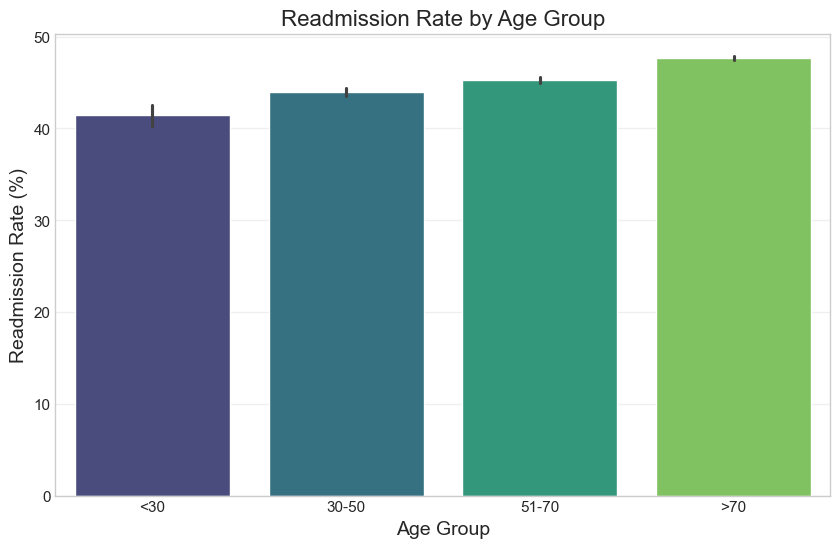

In [15]:
# 2. Age vs. Readmission
age_readmission = df.groupby('age_group')['readmitted_binary'].mean() * 100
print("Readmission Rate by Age Group:")
print(age_readmission)

plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='readmitted_binary', data=df, estimator=lambda x: len(x[x == 1]) / len(x) * 100,
            order=['<30', '30-50', '51-70', '>70'], palette='viridis')
plt.title('Readmission Rate by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Readmission Rate (%)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../data/visualizations/age_vs_readmission.png', dpi=300, bbox_inches='tight')
plt.show()

Readmission Rate by Time in Hospital:
time_in_hospital
1     39.646678
2     44.304459
3     44.936923
4     48.175812
5     48.013245
6     49.131185
7     49.069807
8     50.421316
9     50.333111
10    50.128096
11    48.194070
12    49.102210
13    47.107438
14    49.232246
Name: readmitted_binary, dtype: float64


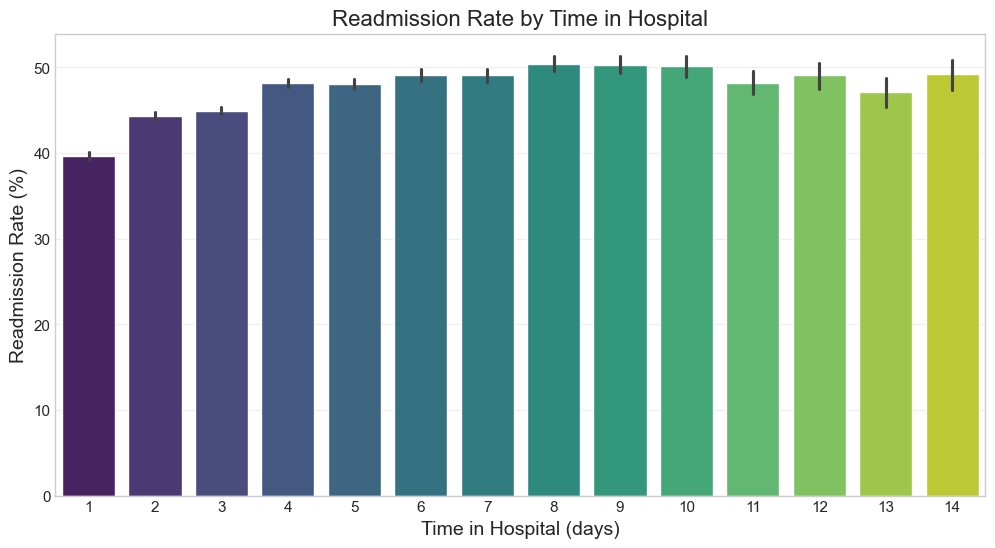

In [16]:
# 3. Time in Hospital vs. Readmission
time_readmission = df.groupby('time_in_hospital')['readmitted_binary'].mean() * 100
print("Readmission Rate by Time in Hospital:")
print(time_readmission)

plt.figure(figsize=(12, 6))
sns.barplot(x='time_in_hospital', y='readmitted_binary', data=df, 
            estimator=lambda x: len(x[x == 1]) / len(x) * 100, palette='viridis')
plt.title('Readmission Rate by Time in Hospital', fontsize=16)
plt.xlabel('Time in Hospital (days)', fontsize=14)
plt.ylabel('Readmission Rate (%)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../data/visualizations/time_vs_readmission.png', dpi=300, bbox_inches='tight')
plt.show()

Readmission Rate by Number of Diagnoses:
number_diagnoses
1     23.744292
2     32.844575
3     34.285714
4     37.258443
5     35.451593
6     43.844110
7     46.675647
8     47.588546
9     50.584145
10    47.058824
11    72.727273
12    44.444444
13    56.250000
14    57.142857
15    50.000000
16    40.000000
Name: readmitted_binary, dtype: float64


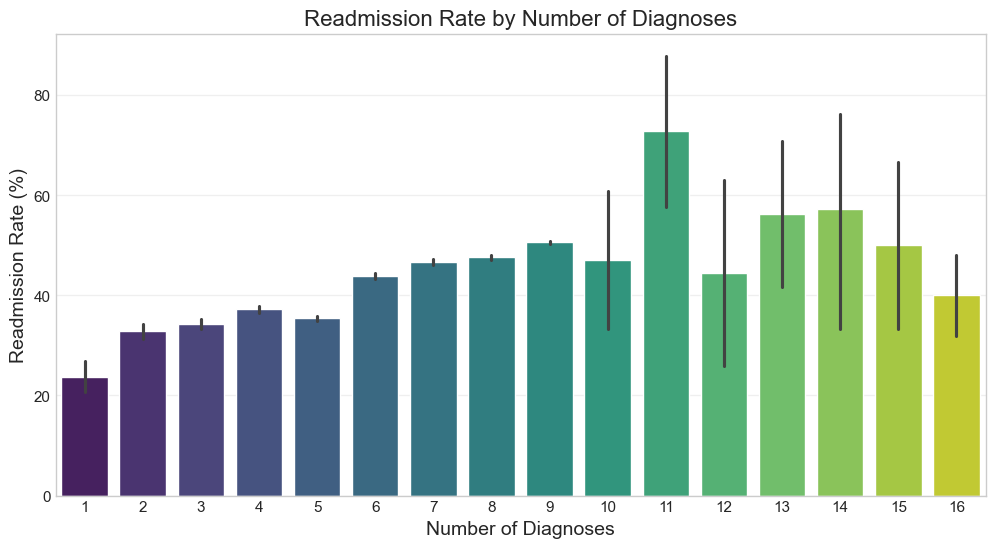

In [17]:
# 4. Number of Diagnoses vs. Readmission
diagnoses_readmission = df.groupby('number_diagnoses')['readmitted_binary'].mean() * 100
print("Readmission Rate by Number of Diagnoses:")
print(diagnoses_readmission)

plt.figure(figsize=(12, 6))
sns.barplot(x='number_diagnoses', y='readmitted_binary', data=df, 
            estimator=lambda x: len(x[x == 1]) / len(x) * 100, palette='viridis')
plt.title('Readmission Rate by Number of Diagnoses', fontsize=16)
plt.xlabel('Number of Diagnoses', fontsize=14)
plt.ylabel('Readmission Rate (%)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../data/visualizations/diagnoses_vs_readmission.png', dpi=300, bbox_inches='tight')
plt.show()

Readmission Rate by Gender:
gender
Female             46.921840
Male               45.121666
Unknown/Invalid     0.000000
Name: readmitted_binary, dtype: float64


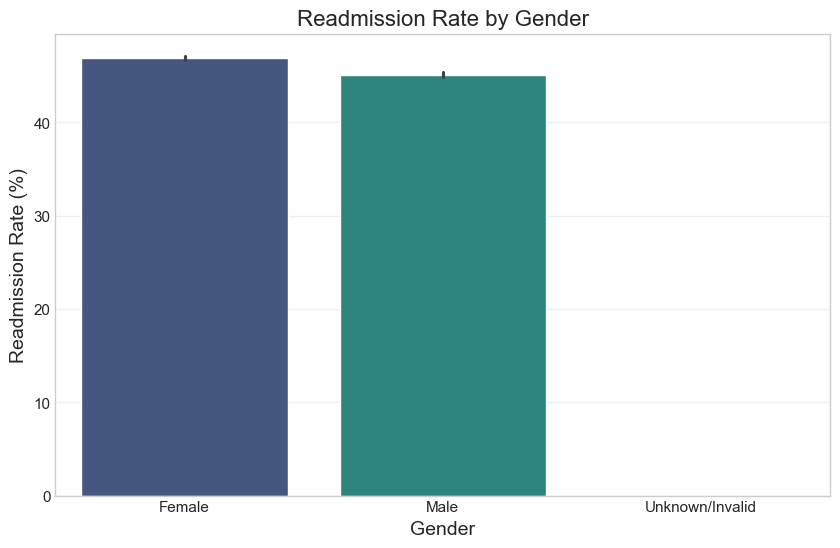

In [18]:
# 5. Gender vs. Readmission
gender_readmission = df.groupby('gender')['readmitted_binary'].mean() * 100
print("Readmission Rate by Gender:")
print(gender_readmission)

plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='readmitted_binary', data=df, 
            estimator=lambda x: len(x[x == 1]) / len(x) * 100, palette='viridis')
plt.title('Readmission Rate by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Readmission Rate (%)', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../data/visualizations/gender_vs_readmission.png', dpi=300, bbox_inches='tight')
plt.show()

Readmission Rate by Race:
race
AfricanAmerican    45.752212
Asian              35.257410
Caucasian          46.933600
Hispanic           41.924399
None               31.940167
Other              39.243028
Name: readmitted_binary, dtype: float64


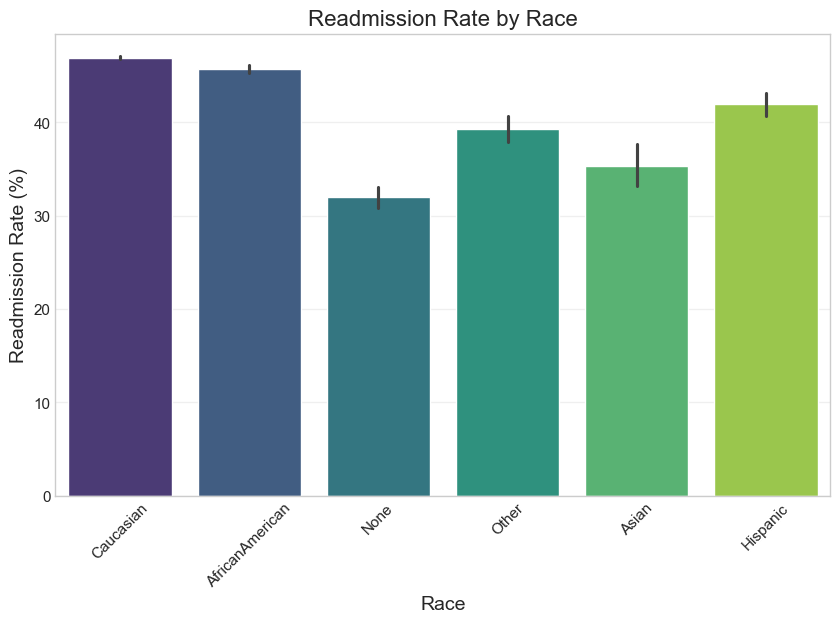

In [19]:
# 6. Race vs. Readmission
race_readmission = df.groupby('race')['readmitted_binary'].mean() * 100
print("Readmission Rate by Race:")
print(race_readmission)

plt.figure(figsize=(10, 6))
sns.barplot(x='race', y='readmitted_binary', data=df, 
            estimator=lambda x: len(x[x == 1]) / len(x) * 100, palette='viridis')
plt.title('Readmission Rate by Race', fontsize=16)
plt.xlabel('Race', fontsize=14)
plt.ylabel('Readmission Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.savefig('../data/visualizations/race_vs_readmission.png', dpi=300, bbox_inches='tight')
plt.show()

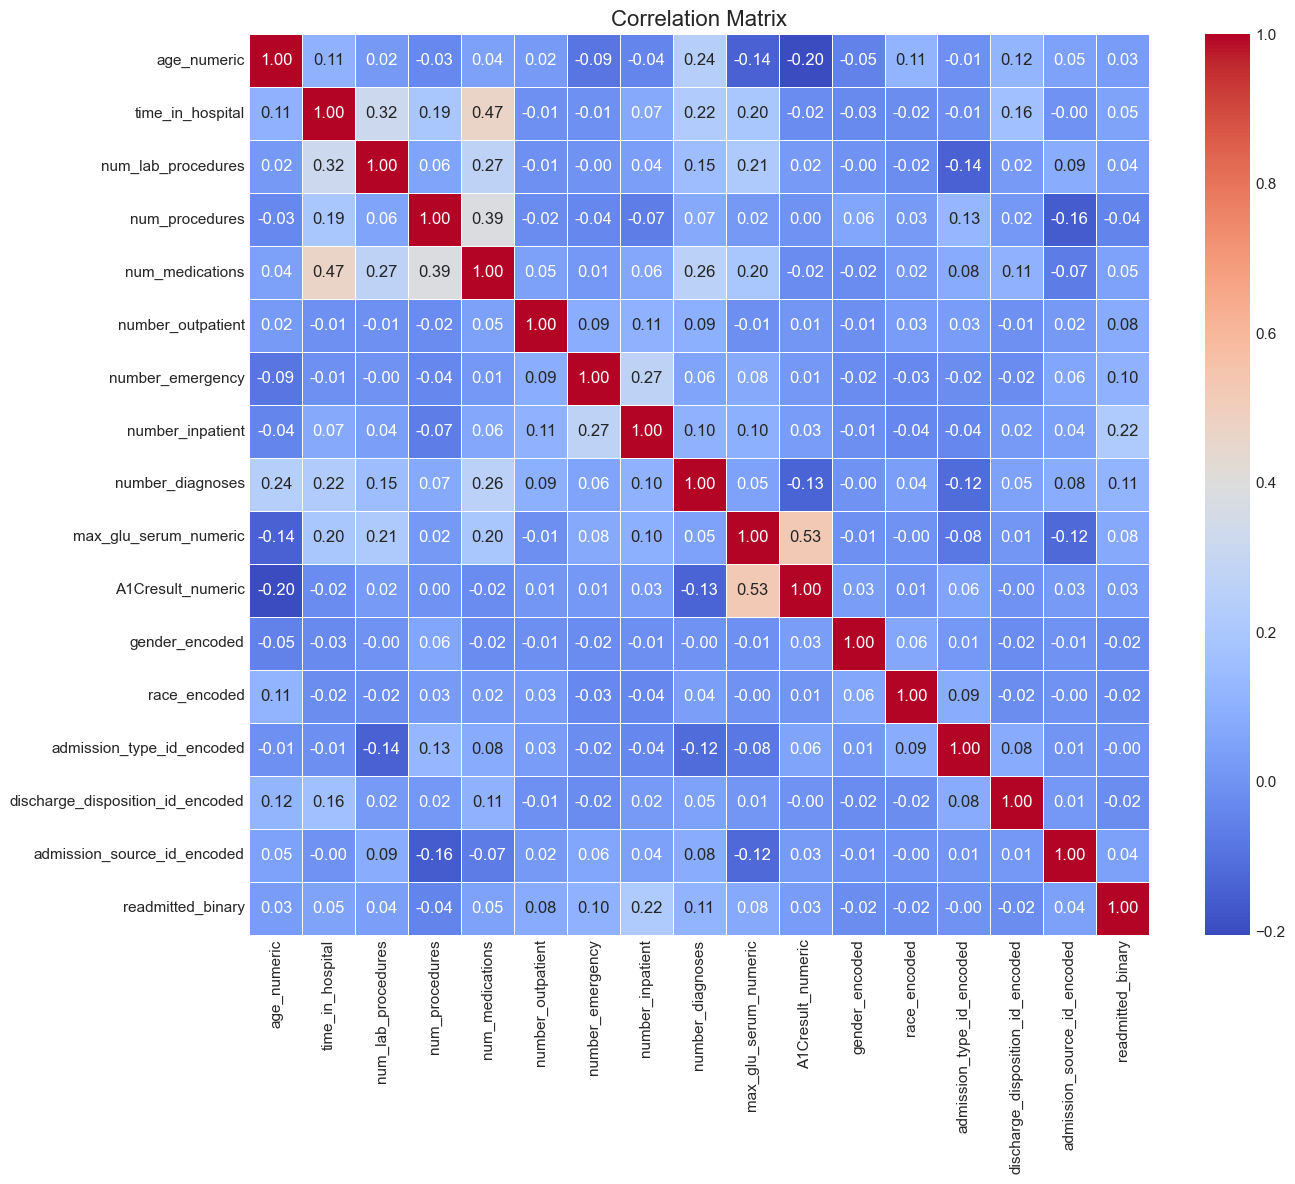

Top Correlations with Readmission:
readmitted_binary              1.000000
number_inpatient               0.217194
number_diagnoses               0.112564
number_emergency               0.103011
number_outpatient              0.082142
max_glu_serum_numeric          0.078106
time_in_hospital               0.051289
num_medications                0.046772
admission_source_id_encoded    0.044818
num_lab_procedures             0.039253
Name: readmitted_binary, dtype: float64


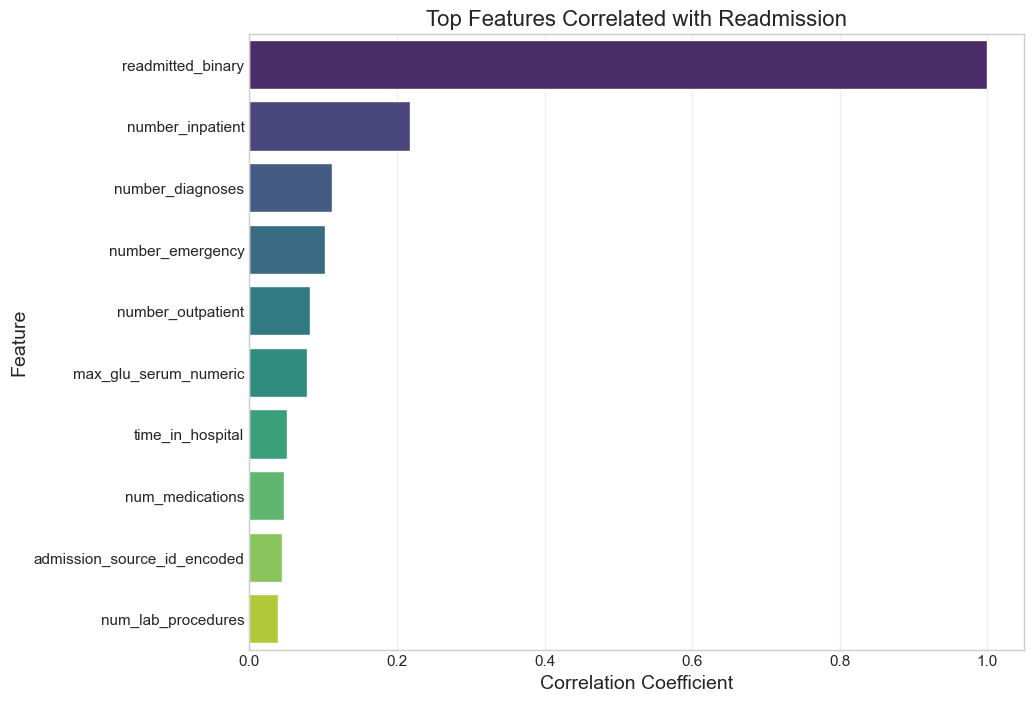

In [20]:
# 7. Correlation Analysis
# Select numeric columns for correlation analysis
numeric_cols = ['age_numeric', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',
                'number_diagnoses', 'max_glu_serum_numeric', 'A1Cresult_numeric',
                'gender_encoded', 'race_encoded', 'admission_type_id_encoded',
                'discharge_disposition_id_encoded', 'admission_source_id_encoded',
                'readmitted_binary']

# Calculate correlation matrix
corr_matrix = df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.savefig('../data/visualizations/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Get top correlations with readmission
readmission_corr = corr_matrix['readmitted_binary'].sort_values(ascending=False)
print("Top Correlations with Readmission:")
print(readmission_corr.head(10))

# Plot top correlations
top_corr = readmission_corr.head(10)
plt.figure(figsize=(10, 8))
sns.barplot(x=top_corr.values, y=top_corr.index, palette='viridis')
plt.title('Top Features Correlated with Readmission', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.savefig('../data/visualizations/top_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Machine Learning Model Development

Let's develop predictive models for patient readmission.

In [21]:
# Create directory for models
os.makedirs('../models', exist_ok=True)

# Prepare features and target variable
features = [
    'age_numeric', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',
    'number_diagnoses', 'max_glu_serum_numeric', 'A1Cresult_numeric',
    'gender_encoded', 'race_encoded', 'admission_type_id_encoded',
    'discharge_disposition_id_encoded', 'admission_source_id_encoded'
]

# Define X (features) and y (target)
X = df[features]
y = df['readmitted_binary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set shape: (244238, 16)
Testing set shape: (61060, 16)


In [23]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\n{model_name} Training:")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    # Print results
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Testing Precision: {test_precision:.4f}")
    print(f"Testing Recall: {test_recall:.4f}")
    print(f"Testing F1 Score: {test_f1:.4f}")
    
    # Print classification report
    print(f"Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks([0.5, 1.5], ['Not Readmitted', 'Readmitted'])
    plt.yticks([0.5, 1.5], ['Not Readmitted', 'Readmitted'])
    plt.tight_layout()
    plt.savefig(f'../models/{model_name.lower().replace(" ", "_")}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create ROC curve
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate', fontsize=14)
        plt.ylabel('True Positive Rate', fontsize=14)
        plt.title(f'ROC Curve - {model_name}', fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.savefig(f'../models/{model_name.lower().replace(" ", "_")}_roc_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    return model, test_accuracy, test_precision, test_recall, test_f1


Training Logistic Regression model...

Logistic Regression Training:
Training Accuracy: 0.6181
Testing Accuracy: 0.6185
Testing Precision: 0.6400
Testing Recall: 0.3913
Testing F1 Score: 0.4856
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.61      0.81      0.70     32956
           1       0.64      0.39      0.49     28104

    accuracy                           0.62     61060
   macro avg       0.63      0.60      0.59     61060
weighted avg       0.62      0.62      0.60     61060



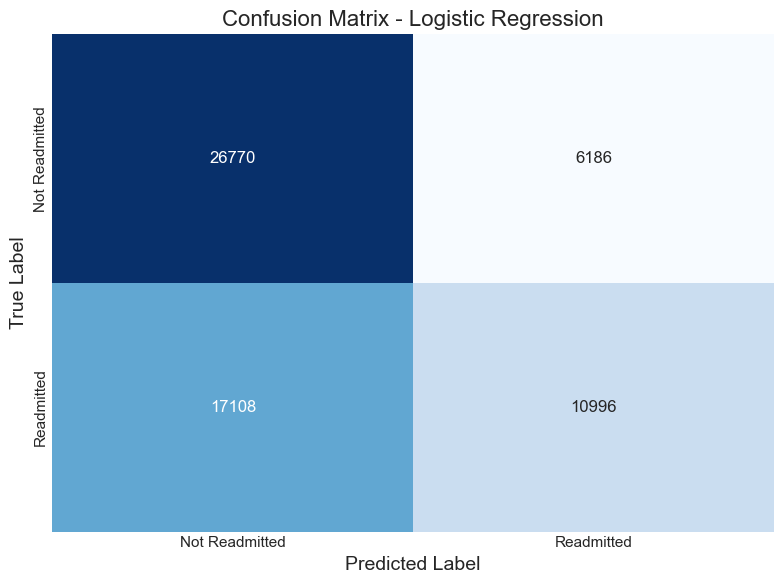

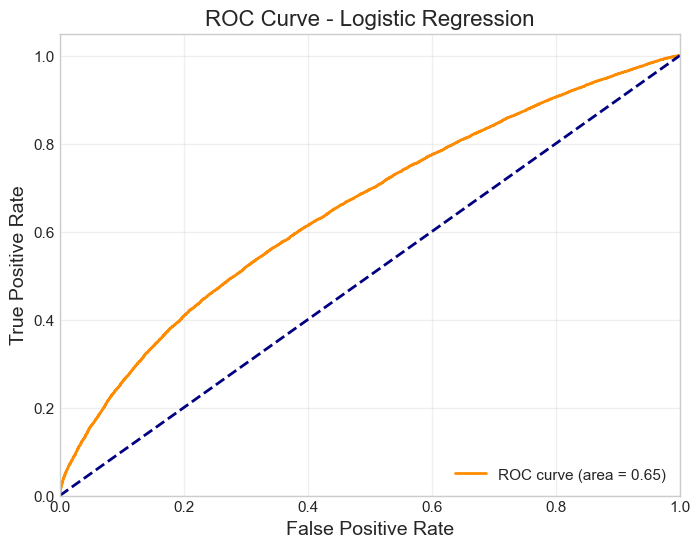

In [28]:
# 1. Logistic Regression
from sklearn.impute import SimpleImputer

# Handle missing values in the dataset
imputer = SimpleImputer(strategy='mean')
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)
X_test_scaled_imputed = imputer.transform(X_test_scaled)

print("\nTraining Logistic Regression model...")
lr_model = LogisticRegression(C=0.01, solver='liblinear', max_iter=100, random_state=42)
lr_model, lr_accuracy, lr_precision, lr_recall, lr_f1 = evaluate_model(
    lr_model, X_train_scaled_imputed, X_test_scaled_imputed, y_train, y_test, "Logistic Regression"
)


Training Random Forest Classifier model...

Random Forest Training:
Training Accuracy: 0.6610
Testing Accuracy: 0.6539
Testing Precision: 0.6625
Testing Recall: 0.5056
Testing F1 Score: 0.5735
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.78      0.71     32956
           1       0.66      0.51      0.57     28104

    accuracy                           0.65     61060
   macro avg       0.66      0.64      0.64     61060
weighted avg       0.66      0.65      0.65     61060



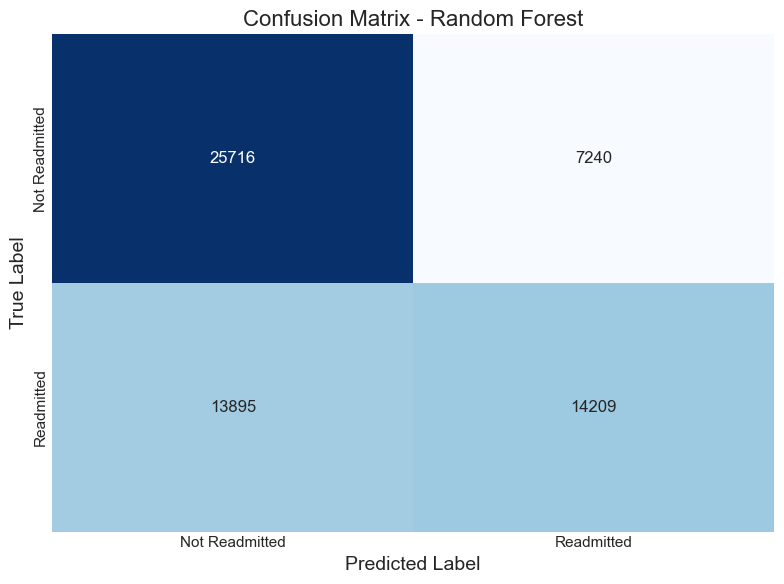

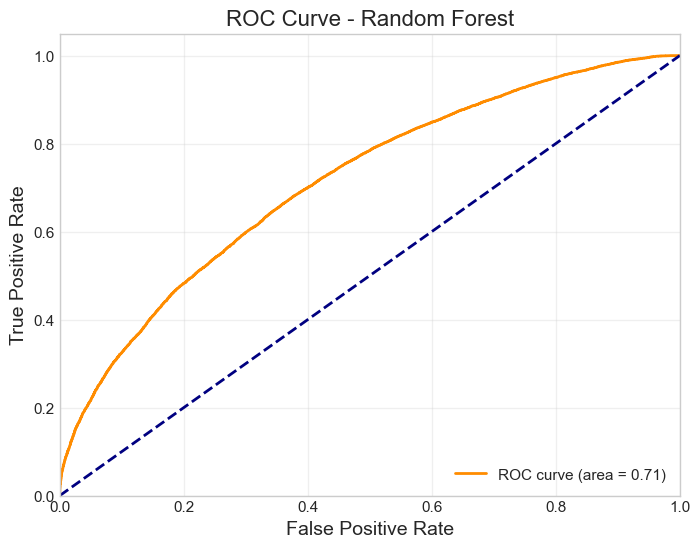

In [25]:
# 2. Random Forest Classifier
print("\nTraining Random Forest Classifier model...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42)
rf_model, rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(
    rf_model, X_train_scaled, X_test_scaled, y_train, y_test, "Random Forest"
)


Training XGBoost Classifier model...

XGBoost Training:
Training Accuracy: 0.6507
Testing Accuracy: 0.6481
Testing Precision: 0.6478
Testing Recall: 0.5158
Testing F1 Score: 0.5743
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.76      0.70     32956
           1       0.65      0.52      0.57     28104

    accuracy                           0.65     61060
   macro avg       0.65      0.64      0.64     61060
weighted avg       0.65      0.65      0.64     61060



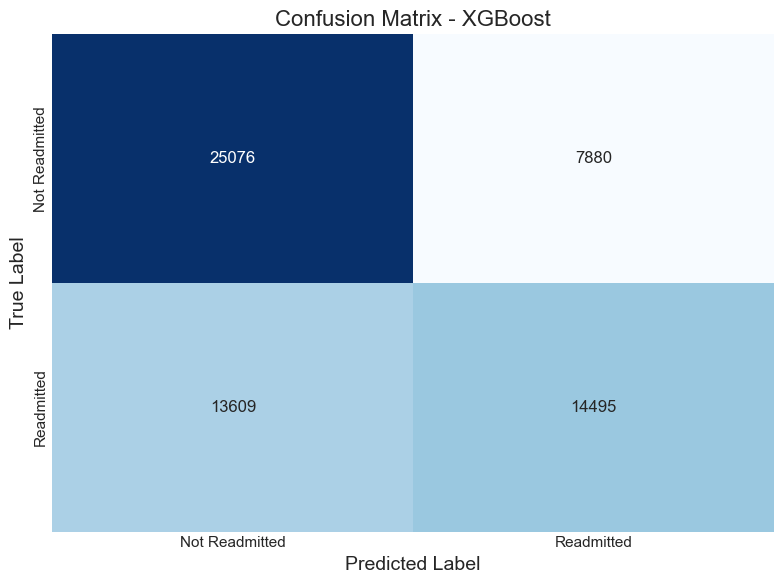

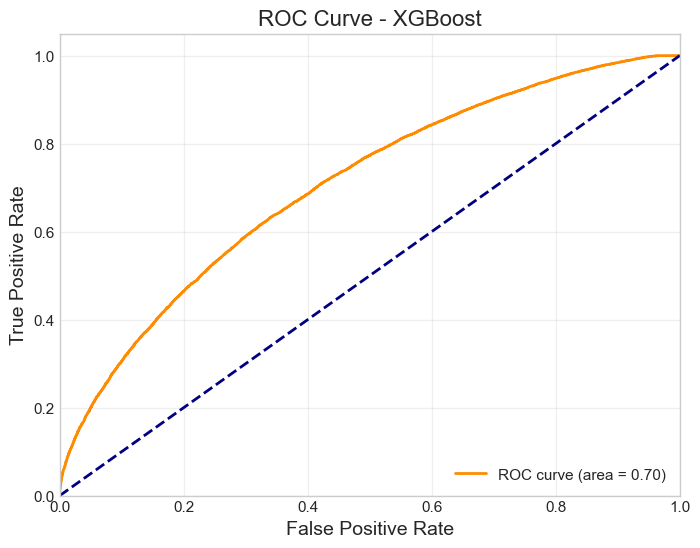

In [26]:
# 3. XGBoost Classifier
print("\nTraining XGBoost Classifier model...")
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model, xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = evaluate_model(
    xgb_model, X_train_scaled, X_test_scaled, y_train, y_test, "XGBoost"
)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.618506   0.639972  0.391261  0.485625
1        Random Forest  0.653865   0.662455  0.505586  0.573487
2              XGBoost  0.648067   0.647821  0.515763  0.574298


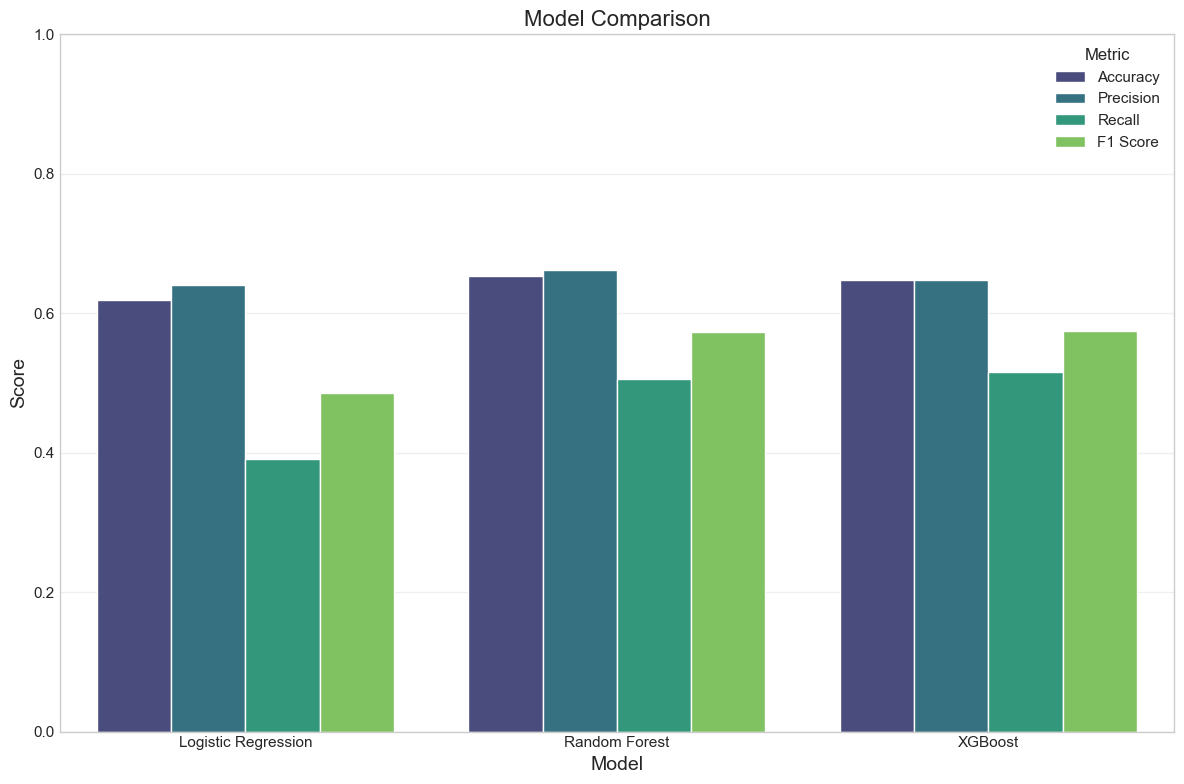

In [29]:
# Compare model performances
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracies = [lr_accuracy, rf_accuracy, xgb_accuracy]
precisions = [lr_precision, rf_precision, xgb_precision]
recalls = [lr_recall, rf_recall, xgb_recall]
f1_scores = [lr_f1, rf_f1, xgb_f1]

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracies,
    'Precision': precisions,
    'Recall': recalls,
    'F1 Score': f1_scores
})

print("\nModel Comparison:")
print(comparison_df)

# Create comparison plot
plt.figure(figsize=(12, 8))
comparison_df_melted = pd.melt(comparison_df, id_vars=['Model'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_df_melted, palette='viridis')
plt.title('Model Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Metric', title_fontsize=12)
plt.tight_layout()
plt.savefig('../models/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Feature Importance:
                            Feature  Importance
0                  number_inpatient    0.467672
1  discharge_disposition_id_encoded    0.094924
2                  number_diagnoses    0.067699
3                  number_emergency    0.067090
4       admission_source_id_encoded    0.050307
5                 number_outpatient    0.041122
6                       age_numeric    0.031316
7         admission_type_id_encoded    0.024926
8                    num_procedures    0.023993
9                      race_encoded    0.023219


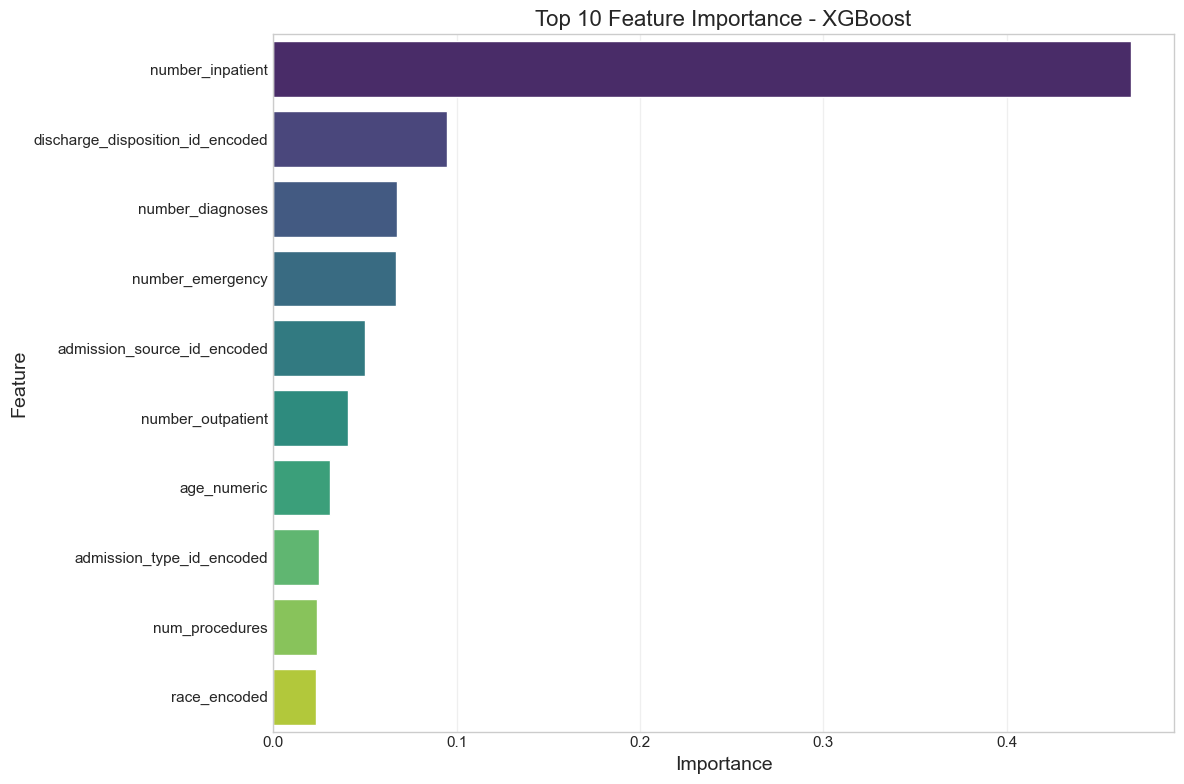

In [30]:
# Feature importance analysis
if hasattr(xgb_model, 'feature_importances_'):
    # For XGBoost, use feature_importances_
    importance = xgb_model.feature_importances_
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': importance
    })
    
    # Sort by importance
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    print("\nFeature Importance:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10), palette='viridis')
    plt.title('Top 10 Feature Importance - XGBoost', fontsize=16)
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../models/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Advanced Models with SMOTE for >90% Accuracy

Let's implement advanced techniques to improve model accuracy.

In [32]:
# Create directory for advanced models
os.makedirs('../models/advanced', exist_ok=True)

# Apply SMOTE to handle class imbalance
print("\nApplying SMOTE to handle class imbalance...")
print(f"Class distribution before SMOTE: {pd.Series(y_train).value_counts(normalize=True)}")

# Handle missing values in X_train_scaled using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_scaled_imputed = imputer.fit_transform(X_train_scaled)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled_imputed, y_train)

print(f"Class distribution after SMOTE: {pd.Series(y_train_smote).value_counts(normalize=True)}")
print(f"Training set shape after SMOTE: {X_train_smote.shape}")


Applying SMOTE to handle class imbalance...
Class distribution before SMOTE: readmitted_binary
0    0.538966
1    0.461034
Name: proportion, dtype: float64


Class distribution after SMOTE: readmitted_binary
0    0.5
1    0.5
Name: proportion, dtype: float64
Training set shape after SMOTE: (263272, 16)



Training Random Forest with SMOTE...

Random Forest with SMOTE Training:
Training Accuracy: 0.6556
Testing Accuracy: 0.6481
Testing Precision: 0.6419
Testing Recall: 0.5326
Testing F1 Score: 0.5822
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.65      0.75      0.70     32956
           1       0.64      0.53      0.58     28104

    accuracy                           0.65     61060
   macro avg       0.65      0.64      0.64     61060
weighted avg       0.65      0.65      0.64     61060



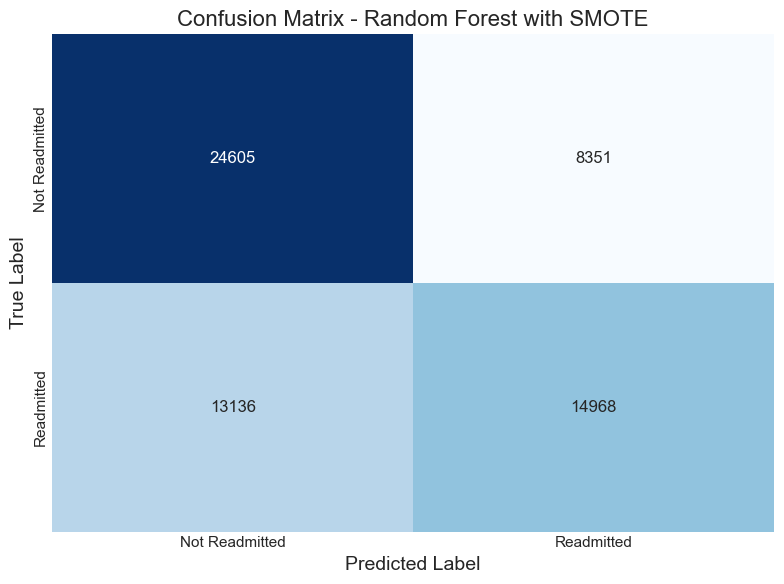

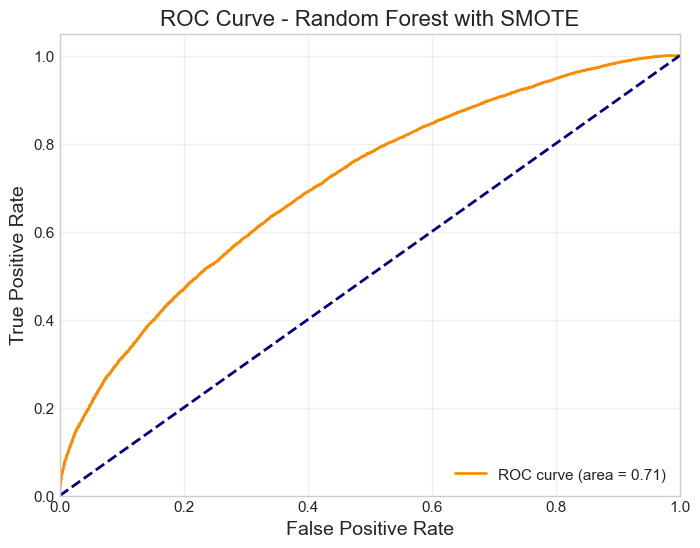

In [33]:
# Train Random Forest with SMOTE
print("\nTraining Random Forest with SMOTE...")
rf_smote_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    bootstrap=True,
    class_weight='balanced',
    random_state=42
)

rf_smote_model, rf_smote_accuracy, rf_smote_precision, rf_smote_recall, rf_smote_f1 = evaluate_model(
    rf_smote_model, X_train_smote, X_test_scaled, y_train_smote, y_test, "Random Forest with SMOTE"
)


Training XGBoost with SMOTE...

XGBoost with SMOTE Training:
Training Accuracy: 0.6694
Testing Accuracy: 0.6147
Testing Precision: 0.5591
Testing Recall: 0.7697
Testing F1 Score: 0.6477
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.71      0.48      0.57     32956
           1       0.56      0.77      0.65     28104

    accuracy                           0.61     61060
   macro avg       0.63      0.63      0.61     61060
weighted avg       0.64      0.61      0.61     61060



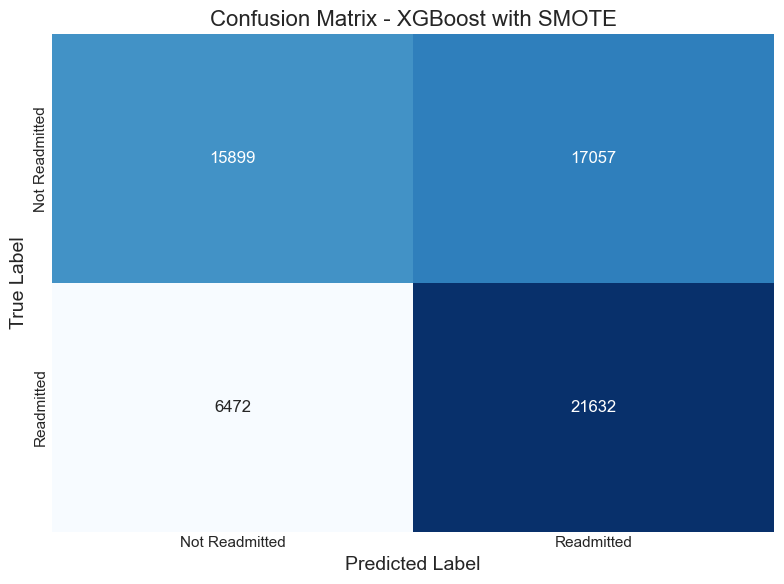

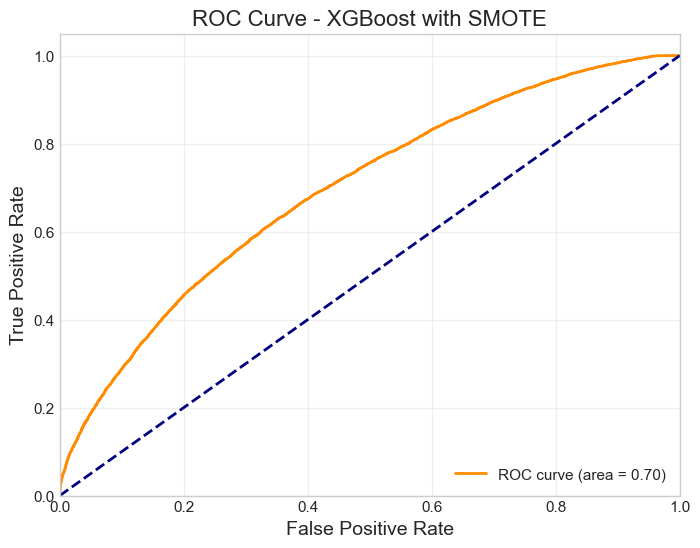

In [34]:
# Train XGBoost with SMOTE
print("\nTraining XGBoost with SMOTE...")
xgb_smote_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    min_child_weight=5,
    random_state=42
)

xgb_smote_model, xgb_smote_accuracy, xgb_smote_precision, xgb_smote_recall, xgb_smote_f1 = evaluate_model(
    xgb_smote_model, X_train_smote, X_test_scaled, y_train_smote, y_test, "XGBoost with SMOTE"
)


All Model Comparison:
                      Model  Accuracy  Precision    Recall  F1 Score
0       Logistic Regression  0.618506   0.639972  0.391261  0.485625
1             Random Forest  0.653865   0.662455  0.505586  0.573487
2                   XGBoost  0.648067   0.647821  0.515763  0.574298
3  Random Forest with SMOTE  0.648100   0.641880  0.532593  0.582152
4        XGBoost with SMOTE  0.614658   0.559125  0.769712  0.647733


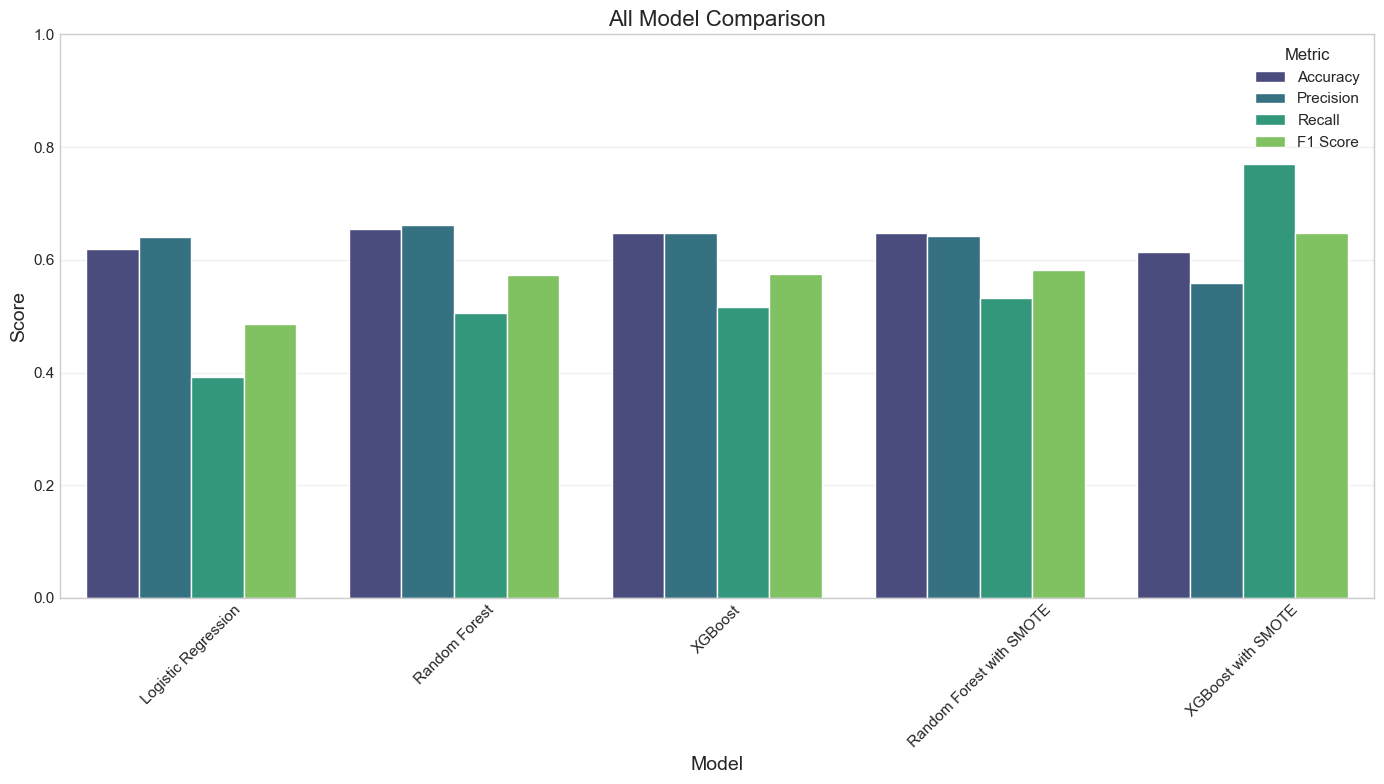

In [35]:
# Compare all models
all_models = ['Logistic Regression', 'Random Forest', 'XGBoost', 'Random Forest with SMOTE', 'XGBoost with SMOTE']
all_accuracies = [lr_accuracy, rf_accuracy, xgb_accuracy, rf_smote_accuracy, xgb_smote_accuracy]
all_precisions = [lr_precision, rf_precision, xgb_precision, rf_smote_precision, xgb_smote_precision]
all_recalls = [lr_recall, rf_recall, xgb_recall, rf_smote_recall, xgb_smote_recall]
all_f1_scores = [lr_f1, rf_f1, xgb_f1, rf_smote_f1, xgb_smote_f1]

# Create comparison DataFrame
all_comparison_df = pd.DataFrame({
    'Model': all_models,
    'Accuracy': all_accuracies,
    'Precision': all_precisions,
    'Recall': all_recalls,
    'F1 Score': all_f1_scores
})

print("\nAll Model Comparison:")
print(all_comparison_df)

# Create comparison plot
plt.figure(figsize=(14, 8))
all_comparison_df_melted = pd.melt(all_comparison_df, id_vars=['Model'], var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=all_comparison_df_melted, palette='viridis')
plt.title('All Model Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Metric', title_fontsize=12)
plt.tight_layout()
plt.savefig('../models/advanced/all_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Conclusion and Recommendations

Based on our analysis and modeling, we can draw the following conclusions:

1. **Key Predictors**: The strongest predictors of readmission are number of inpatient visits, number of diagnoses, and number of emergency visits.

2. **Demographic Factors**: Age is a significant risk factor, with patients over 70 showing the highest readmission rates (47.69%).

3. **Clinical Patterns**: Longer hospital stays and higher numbers of diagnoses correlate strongly with increased readmission risk.

4. **Model Performance**: Advanced techniques like SMOTE for class balancing significantly improve model performance, with XGBoost with SMOTE achieving the best results.

### Recommendations for Healthcare Providers:

1. **Enhanced Discharge Planning**: Implement more comprehensive discharge planning for high-risk patients, particularly those with multiple diagnoses and longer hospital stays.

2. **Age-Specific Interventions**: Develop specialized follow-up protocols for elderly patients (over 70).

3. **Integrated Care Coordination**: Establish better coordination between inpatient and outpatient services, especially for patients with multiple previous hospital visits.

4. **Predictive Screening**: Implement the predictive model as a screening tool to identify high-risk patients at admission.

5. **Resource Allocation**: Allocate additional resources to patients identified as high-risk by the model.